<a href="https://colab.research.google.com/github/slp22/deep-learning-project/blob/main/dl_diabetic_retinopathy_mvp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Deep Learning | MVP

# Diabetic Retinopathy<a id='top'></a> 

## **Analysis Goal**  
The client, the [National Eye Institute](https://www.nei.nih.gov/), part of the National Institutes of Health, wants a model that can quickly identify [diabetic retinopathy](https://www.nei.nih.gov/learn-about-eye-health/eye-conditions-and-diseases/diabetic-retinopathy) in patients participating in early phase clinical trials.

**RQ:** How well can a neural network diagnose diabetic retinopathy from a retinal image?


## **Process**
**Data source:** [Diabetic Retinopathy](https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-2015-data-colored-resized)retinal images at various stages of the disease, modified from the [Diabetic Retinopathy Detection Kaggle Competition](https://www.kaggle.com/c/diabetic-retinopathy-detection); images are courtesy of [EyePACS](http://eyepacs.com/),a free platform for retinopathy screening. The dataset (n=35,126) is classified as:  
  0 - No_DR (healthy eye)
  1 - Mild
  2 - Moderate
  3 - Severe
  4 - Proliferate_DR

**Error Metric:** Precision and recall 

**Models:** 
  * First iteration, basic deep learning model:
    * recall score on X_test and y_test: ###
    * precision score on y_validate and y_predict: ###
    * ROC AUC score: ###

## **Preliminary Visualizations**
Figure 1. EDA
Figure 2. ROC Curve ???
Figure 3. ROC Curve ???

## **Preliminary Conclusions**
The baseline logistic regression model scored less well/better on recall and precision that the first iteration deep learning model. 

The next step for this analysis is to classify ... 

## imports

In [19]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os, shutil
import pandas as pd
import pickle
import PIL
import random
import seaborn as sns
import shutil
import sklearn as sk
import tensorflow as tf
import warnings

from glob import glob
from tensorflow import keras
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import Sequential
from keras.preprocessing import image as IMG
from keras.preprocessing.image import ImageDataGenerator
# from keras.utils import to_categorical

from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

%pylab inline
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']  # or svg
pd.set_option('display.max_colwidth', None)
sns.set(context='notebook', style='whitegrid')
warnings.filterwarnings('ignore')

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Matplotlib version:", matplotlib.__version__)
print("Numpy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("TensorFlow version:", tf.__version__)
print("Keras Version:", tf.keras.__version__)
print("Scikit-learn version:", sk.__version__)


Populating the interactive namespace from numpy and matplotlib
Num GPUs Available:  0
Matplotlib version: 3.2.2
Numpy version: 1.21.6
Pandas version: 1.3.5
TensorFlow version: 2.8.2
Keras Version: 2.8.0
Scikit-learn version: 1.0.2


## 1 | Dataset: [Diabetic Retinopathy Retinal Images](https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-2015-data-colored-resized)

Code adapted from [github/PurpleGrace](https://github.com/PurpleGrace/Deep_Learning_Tools_Image_Classification/blob/main/code/1.EDA_Sample_Images.ipynb)


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sandralparedes","key":"52716e458c895e3e9d7fcfde80b0d59e"}'}

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! pwd
! ls

/content
drive  kaggle.json  sample_data


In [5]:
import zipfile
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [6]:
! kaggle datasets download -d sovitrath/diabetic-retinopathy-2015-data-colored-resized

 99% 1.92G/1.94G [00:15<00:00, 186MB/s]
100% 1.94G/1.94G [00:15<00:00, 134MB/s]


In [ ]:
# unzip kaggle file

zip_ref = zipfile.ZipFile('diabetic-retinopathy-2015-data-colored-resized.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [136]:
# show number of classes and images

source_images_path = '/tmp/colored_images/colored_images/'
extracted_directories_path = os.listdir(source_images_path)

for image_directory in extracted_directories_path:
  print(image_directory, len(os.listdir(os.path.join(source_images_path, image_directory))))

Moderate 5292
No_DR 25810
Mild 2443
Severe 873
Proliferate_DR 708


## 2 | Exploratory Data Analysis

In [134]:
# read in files and diagnosis label and store as dataframe

filepath = '/tmp/colored_images/colored_images'
dataframe = {'image_path':[],'diagnosis':[]}

for diagnosis in os.listdir(filepath):
    print(diagnosis)
    if diagnosis != 'colored_images':        
        for image in os.listdir(filepath +"/"+diagnosis):
            if image != 'Dataset':
                dataframe['image_path'].append(filepath +"/"+diagnosis+"/"+ image)
                dataframe['diagnosis'].append(diagnosis)
dataframe = pd.DataFrame(dataframe)  
dataframe.info()
dataframe.head(2)

Moderate
No_DR
Mild
Severe
Proliferate_DR
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35126 entries, 0 to 35125
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  35126 non-null  object
 1   diagnosis   35126 non-null  object
dtypes: object(2)
memory usage: 549.0+ KB


,image_path,diagnosis
0,/tmp/colored_images/colored_images/Moderate/1419_right.png,Moderate
1,/tmp/colored_images/colored_images/Moderate/38331_right.png,Moderate


Data set n = 35,126

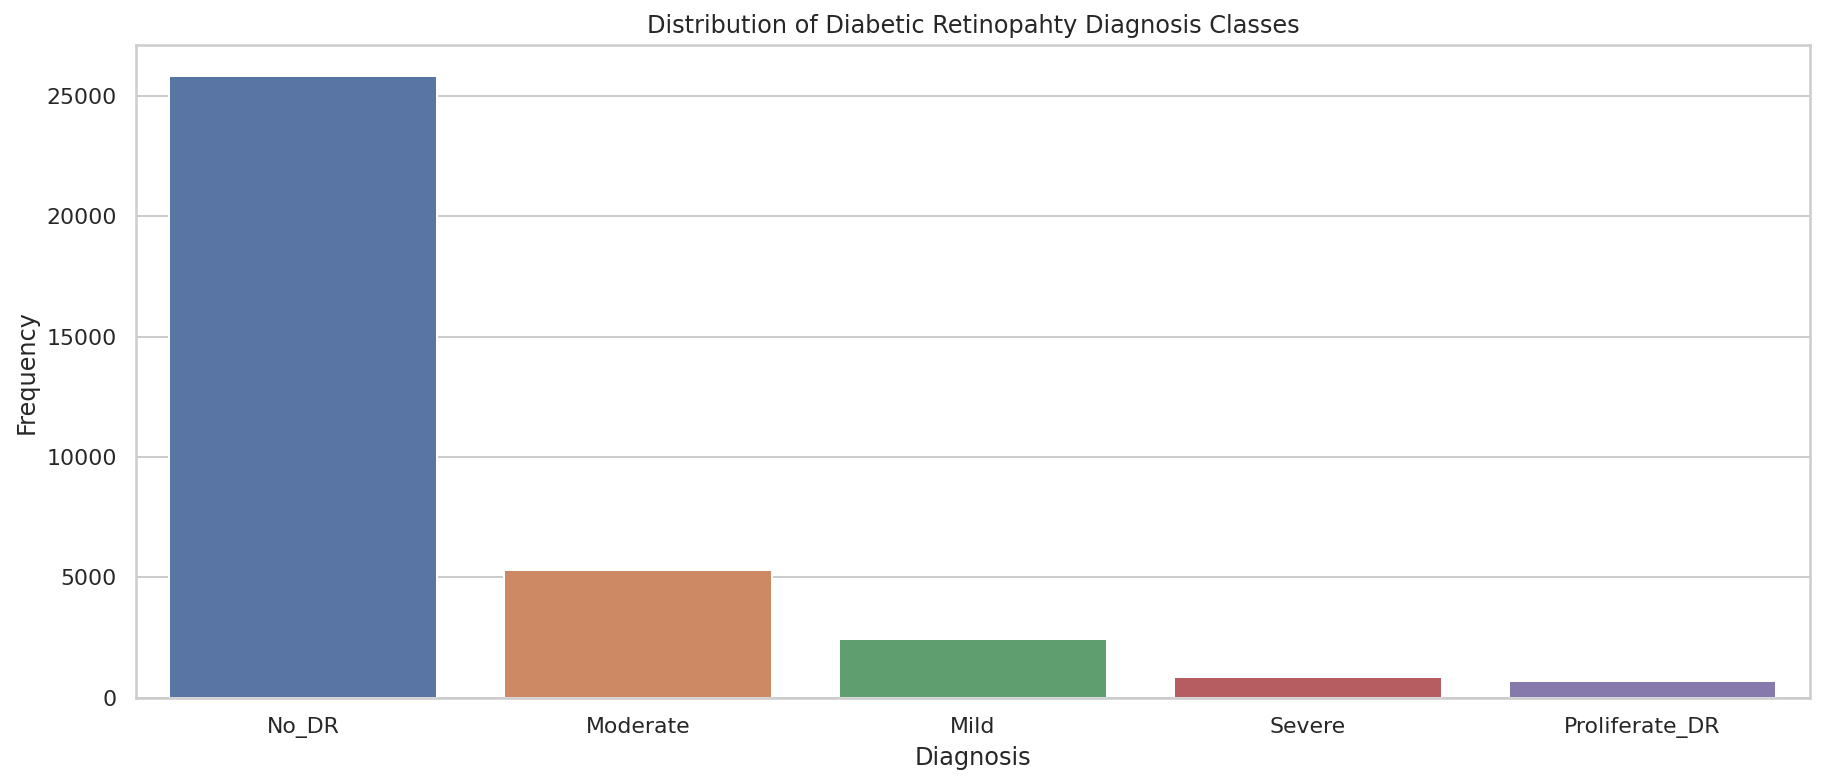

In [100]:
# distribution of diagnosis classes

plt.figure(figsize=(15,6))
sns.barplot(dataframe.diagnosis.value_counts().index,
            dataframe.diagnosis.value_counts(),
            palette=None)
plt.title("Distribution of Diabetic Retinopahty Diagnosis Classes")
plt.xlabel("Diagnosis")
plt.ylabel("Frequency");


Classes are unbalanced

No Diabetic Retinopthy
Datatype: <class 'PIL.PngImagePlugin.PngImageFile'>


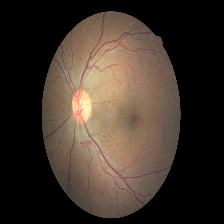

In [101]:
# view one healthy eye image

path = '/tmp/colored_images/colored_images/No_DR/10003_left.png'

healthy_image = tf.keras.preprocessing.image.load_img(
   path,
   grayscale=False, 
   color_mode="rgb", 
  #  target_size=(256, 256),
   interpolation="nearest")

print('No Diabetic Retinopthy')
print('Datatype:', type(healthy_image))
healthy_image 


Proliferate Diabetic Retinopthy
Datatype: <class 'PIL.PngImagePlugin.PngImageFile'>


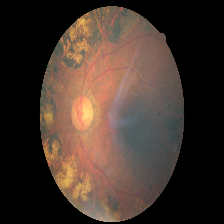

In [102]:
# view one proliferate DR image (most advanced stage of disease)

path = '/tmp/colored_images/colored_images/Proliferate_DR/10017_left.png'

proliferate_image = tf.keras.preprocessing.image.load_img(
   path,
   grayscale=False, 
   color_mode="rgb", 
  #  target_size=(256, 256), 
   interpolation="nearest")

print('Proliferate Diabetic Retinopthy')
print('Datatype:', type(proliferate_image))
proliferate_image 


## 3 | Deep Learning Model

### Validation Split

In [52]:
# set up for train/test split

temp_path = '/tmp'
raw_data_dir_name = 'raw_data'
train_data_dir_name = 'train'
test_data_dir_name = 'test'
raw_data_directories = [train_data_dir_name, test_data_dir_name]

images_path =  os.path.join(temp_path, raw_data_dir_name)
tmp_directories = os.listdir(temp_path)

def build_raw_data_directory(parent, directory):
  dir_path = os.path.join(parent, directory)
  os.mkdir(dir_path)
  for dir in extracted_directories_path:
    os.mkdir(os.path.join(dir_path, dir))

if raw_data_dir_name not in tmp_directories:
  os.mkdir(images_path)
  for directory in raw_data_directories:
    build_raw_data_directory(images_path, directory)
else:
  print(raw_data_dir_name, " already exist")
  images_path_directories = os.listdir(images_path)
  for directory in raw_data_directories:
    if directory not in images_path_directories:
      build_raw_data_directory(images_path, directory)




In [74]:
# split data into train/test folders

# distribution = 0.2

# raw_data_path = os.path.join(temp_path, raw_data_dir_name)
# test_data_path_root = os.path.join(raw_data_path, test_data_dir_name)
# train_data_path_root = os.path.join(raw_data_path, train_data_dir_name)

# data_dirs = os.listdir(source_images_path)
# for dir in data_dirs:
#   path = os.path.join(source_images_path, dir)
#   test_data_path = os.path.join(test_data_path_root, dir)
#   train_data_path = os.path.join(train_data_path_root, dir)
#   images = os.listdir(path)
#   print(path, test_data_path)
#   for image in images:
#     random_number = random.uniform(0, 1)
#     is_test_image = random_number < distribution
#     source_image_path = os.path.join(path, image)
#     # shutil.copy(src, dst)
#     if is_test_image:
#       shutil.copy(source_image_path, test_data_path)
#       # print(source_image_path, "goes to test", test_data_path)
#     else:
#       shutil.copy(source_image_path, train_data_path)
#       # print(source_image_path, "goes to train", train_data_path)

test_data_path_root = os.path.join(raw_data_path, test_data_dir_name)
train_data_path_root = os.path.join(raw_data_path, train_data_dir_name)

test_dirs = os.listdir(test_data_path_root)
train_dirs = os.listdir(train_data_path_root)

for dir in test_dirs:
  path = os.path.join(test_data_path_root, dir)
  files = os.listdir(path)
  print(path, len(files))

for dir in train_dirs:
  path = os.path.join(train_data_path_root, dir)
  files = os.listdir(path)
  print(path, len(files))

/tmp/raw_data/test/Moderate 1041
/tmp/raw_data/test/No_DR 5212
/tmp/raw_data/test/Mild 521
/tmp/raw_data/test/Severe 194
/tmp/raw_data/test/Proliferate_DR 129
/tmp/raw_data/train/Moderate 4251
/tmp/raw_data/train/No_DR 20598
/tmp/raw_data/train/Mild 1922
/tmp/raw_data/train/Severe 679
/tmp/raw_data/train/Proliferate_DR 579


### Deep Learning First Model

Code source: https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d 

In [218]:
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

In [219]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [226]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))



In [227]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [228]:
# batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/tmp/raw_data/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

validation_generator = test_datagen.flow_from_directory(
        '/tmp/raw_data/test',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 28029 images belonging to 5 classes.
Found 7097 images belonging to 5 classes.


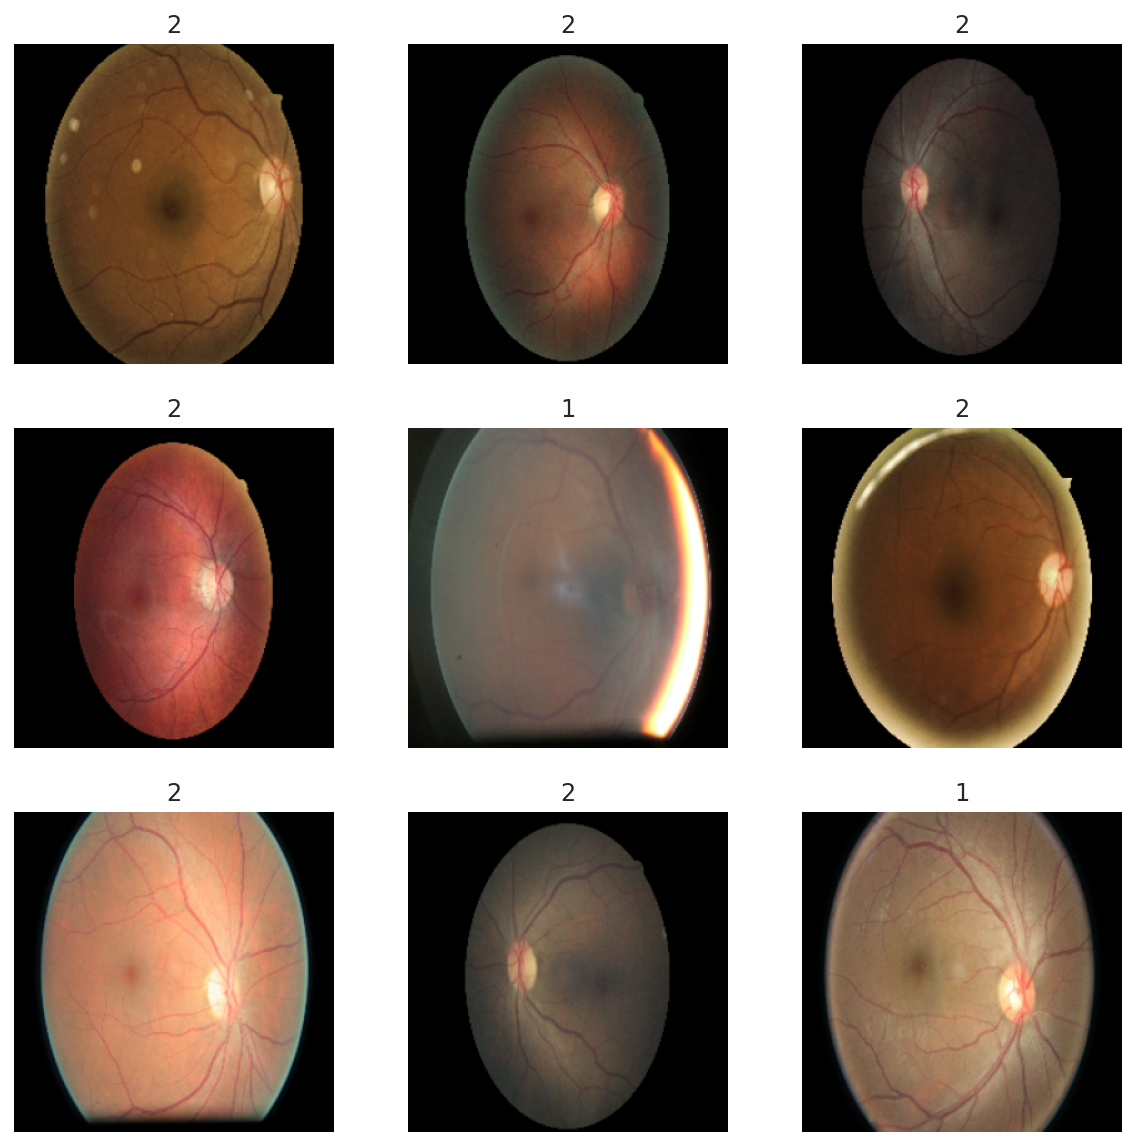

In [235]:
# # show a random sample of each diagnosis 

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

In [230]:
model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size
        )

# model.save_weights('first_try.h5')  # always save your weights after training or during training

Epoch 1/5
125/125 [==============================] - 38s 305ms/step - loss: -131611770880.0000 - accuracy: 0.1442 - val_loss: -188261285888.0000 - val_accuracy: 0.1475
Epoch 2/5
125/125 [==============================] - 39s 313ms/step - loss: -260705796096.0000 - accuracy: 0.1550 - val_loss: -351183634432.0000 - val_accuracy: 0.1375
Epoch 3/5
125/125 [==============================] - 39s 310ms/step - loss: -485996658688.0000 - accuracy: 0.1410 - val_loss: -654728495104.0000 - val_accuracy: 0.1262
Epoch 4/5
125/125 [==============================] - 38s 306ms/step - loss: -816941367296.0000 - accuracy: 0.1665 - val_loss: -1068131352576.0000 - val_accuracy: 0.1388
Epoch 5/5
125/125 [==============================] - 39s 314ms/step - loss: -1367113203712.0000 - accuracy: 0.1445 - val_loss: -1664824508416.0000 - val_accuracy: 0.1625
